In [1]:
#@title NVIDIA GPU
!nvidia-smi 

Wed Mar 29 04:47:11 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
#@title Install `huggingface_hub`, enable custom widget manager
!pip install huggingface_hub

from google.colab import output
output.enable_custom_widget_manager()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 4.4 MB/s eta 0:00:00


In [3]:
#@title Authenticate huggingface token
from huggingface_hub import notebook_login
notebook_login()

Token is valid.
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.cache/huggingface/token
Login successful


# Make necessary installtions

In [4]:
!pip install transformers
!pip install diffusers
!pip install pytorch_lightning
!pip install gradio
!pip install open_clip_torch
!pip install clip_interrogator

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 51.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 91.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 737.4/737.4 KB 12.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 715.6/715.6 KB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 KB 43.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 68.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 KB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 KB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 KB 29

In [5]:
#@title Setup

import os, subprocess
import gradio as gr
from clip_interrogator import Config, Interrogator

clip_model_name = 'ViT-L-14/openai' #@param ["ViT-L-14/openai", "ViT-H-14/laion2b_s32b_b79k"]

config = Config()
config.blip_num_beams = 64
config.blip_offload = False
config.clip_model_name = clip_model_name
ci = Interrogator(config)

def image_analysis(image):
    image = image.convert('RGB')
    image_features = ci.image_to_features(image)

    top_mediums = ci.mediums.rank(image_features, 5)
    top_artists = ci.artists.rank(image_features, 5)
    top_movements = ci.movements.rank(image_features, 5)
    top_trendings = ci.trendings.rank(image_features, 5)
    top_flavors = ci.flavors.rank(image_features, 5)

    medium_ranks = {medium: sim for medium, sim in zip(top_mediums, ci.similarities(image_features, top_mediums))}
    artist_ranks = {artist: sim for artist, sim in zip(top_artists, ci.similarities(image_features, top_artists))}
    movement_ranks = {movement: sim for movement, sim in zip(top_movements, ci.similarities(image_features, top_movements))}
    trending_ranks = {trending: sim for trending, sim in zip(top_trendings, ci.similarities(image_features, top_trendings))}
    flavor_ranks = {flavor: sim for flavor, sim in zip(top_flavors, ci.similarities(image_features, top_flavors))}
    
    return medium_ranks, artist_ranks, movement_ranks, trending_ranks, flavor_ranks

def image_to_prompt(image, mode):
    ci.config.chunk_size = 2048 if ci.config.clip_model_name == "ViT-L-14/openai" else 1024
    ci.config.flavor_intermediate_count = 2048 if ci.config.clip_model_name == "ViT-L-14/openai" else 1024
    image = image.convert('RGB')
    if mode == 'best':
        return ci.interrogate(image)
    elif mode == 'classic':
        return ci.interrogate_classic(image)
    elif mode == 'fast':
        return ci.interrogate_fast(image)
    elif mode == 'negative':
        return ci.interrogate_negative(image)
        

Loading caption model blip-large...


Loading CLIP model ViT-L-14/openai...


100%|████████████████████████████████████████| 933M/933M [00:06<00:00, 151MiB/s]
ViT-L-14_openai_artists.safetensors: 100%|██████████| 16.2M/16.2M [00:00<00:00, 23.0MB/s]
ViT-L-14_openai_flavors.safetensors: 100%|██████████| 155M/155M [00:01<00:00, 138MB/s]
ViT-L-14_openai_mediums.safetensors: 100%|██████████| 146k/146k [00:00<00:00, 3.25MB/s]
ViT-L-14_openai_movements.safetensors: 100%|██████████| 307k/307k [00:00<00:00, 5.01MB/s]
ViT-L-14_openai_trendings.safetensors: 100%|██████████| 111k/111k [00:00<00:00, 2.74MB/s]
ViT-L-14_openai_negative.safetensors: 100%|██████████| 63.2k/63.2k [00:00<00:00, 3.31MB/s]

Loaded CLIP model and data in 18.51 seconds.


In [6]:
cd ..

/


In [7]:
cd content

/content


In [8]:
!mkdir my_images

Generating prompts:   0%|          | 0/4 [00:00<?, ?it/s]

a large group of hay bales are sitting in a field, a matte painting inspired by Modest Urgell, featured on flickr, land art, field of hay, clouds and fields in background, rural landscape


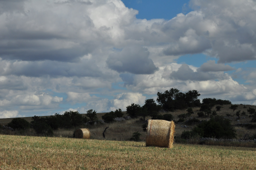

Generating prompts:  25%|██▌       | 1/4 [00:00<00:02,  1.20it/s]

painting of a painting of a painting of a painting of a man on horseback, a detailed matte painting by Fitz Henry Lane, cg society, american scene painting, (colonial expedition), colonial expedition, the age of discovery


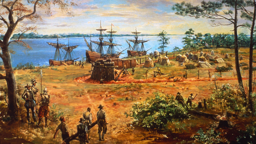

Generating prompts:  50%|█████     | 2/4 [00:01<00:01,  1.11it/s]

arafectible photograph of a city street scene with a horse drawn carriage, a colorized photo inspired by Peter Fiore, reddit contest winner, american barbizon school, 1910s architecture, 1900s, 1 9 0 0 s


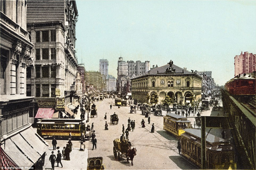

Generating prompts:  75%|███████▌  | 3/4 [00:02<00:00,  1.23it/s]

a crowd of people standing in front of a large building with flags, a microscopic photo by Jeff A. Menges, featured on cg society, neoism, thom wasselmann, associated press photography, associated press


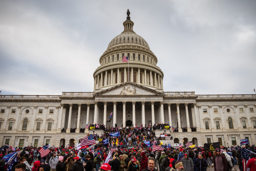

Generating prompts: 100%|██████████| 4/4 [00:03<00:00,  1.22it/s]





Generated 4 prompts and saved to /content/my_images/desc.csv, enjoy!


In [14]:
#@title Batch process a folder of images 📁 -> 📝

#@markdown This will generate prompts for every image in a folder and either save results 
#@markdown to a desc.csv file in the same folder or rename the files to contain their prompts.
#@markdown The renamed files work well for [DreamBooth extension](https://github.com/d8ahazard/sd_dreambooth_extension)
#@markdown in the [Stable Diffusion Web UI](https://github.com/AUTOMATIC1111/stable-diffusion-webui).
#@markdown You can use the generated csv in the [Stable Diffusion Finetuning](https://colab.research.google.com/drive/1vrh_MUSaAMaC5tsLWDxkFILKJ790Z4Bl?usp=sharing)

import csv
import os
from IPython.display import clear_output, display
from PIL import Image
from tqdm import tqdm

folder_path = "/content/my_images" #@param {type:"string"}
prompt_mode = 'classic' #@param ["best","fast","classic","negative"]
output_mode = 'desc.csv' #@param ["desc.csv","rename"]
max_filename_len = 75 #@param {type:"integer"}


def sanitize_for_filename(prompt: str, max_len: int) -> str:
    name = "".join(c for c in prompt if (c.isalnum() or c in ",._-! "))
    name = name.strip()[:(max_len-4)] # extra space for extension
    return name

ci.config.quiet = True

files = [f for f in os.listdir(folder_path) if f.endswith('.jpg') or f.endswith('.png')] if os.path.exists(folder_path) else []
prompts = []
for idx, file in enumerate(tqdm(files, desc='Generating prompts')):
    if idx > 0 and idx % 100 == 0:
        clear_output(wait=True)

    image = Image.open(os.path.join(folder_path, file)).convert('RGB')
    prompt = image_to_prompt(image, prompt_mode)
    prompts.append(prompt)

    print(prompt)
    thumb = image.copy()
    thumb.thumbnail([256, 256])
    display(thumb)

    if output_mode == 'rename':
        name = sanitize_for_filename(prompt, max_filename_len)
        ext = os.path.splitext(file)[1]
        filename = name + ext
        idx = 1
        while os.path.exists(os.path.join(folder_path, filename)):
            print(f'File {filename} already exists, trying {idx+1}...')
            filename = f"{name}_{idx}{ext}"
            idx += 1
        os.rename(os.path.join(folder_path, file), os.path.join(folder_path, filename))

if len(prompts):
    if output_mode == 'desc.csv':
        csv_path = os.path.join(folder_path, 'desc.csv')
        with open(csv_path, 'w', encoding='utf-8', newline='') as f:
            w = csv.writer(f, quoting=csv.QUOTE_MINIMAL)
            w.writerow(['image', 'prompt'])
            for file, prompt in zip(files, prompts):
                w.writerow([file, prompt])

        print(f"\n\n\n\nGenerated {len(prompts)} prompts and saved to {csv_path}, enjoy!")
    else:
        print(f"\n\n\n\nGenerated {len(prompts)} prompts and renamed your files, enjoy!")
else:
    print(f"Sorry, I couldn't find any images in {folder_path}")


In [15]:
#@title Load model
# !pip install diffusers[torch]==0.7.2 transformers accelerate scipy ftfy pytorch_lightning

import torch
from diffusers import StableDiffusionPipeline


def get_device() -> torch.device:
    if torch.cuda.is_available():
        return torch.device("cuda")
    if torch.backends.mps.is_available():
        return torch.device("mps")
    return torch.device("cpu")


device = get_device()
pipe = StableDiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", revision="fp16", torch_dtype=torch.float16
)
pipe = pipe.to(device)
# pipe.enable_sequential_cpu_offload()
# pipe.enable_attention_slicing(1)

/usr/local/lib/python3.9/dist-packages/flax/core/frozen_dict.py:169: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(


vae/diffusion_pytorch_model.safetensors not found


Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


In [16]:
#@title Define `generate` function
import inspect
import logging
from typing import Callable, List, Optional

from PIL.Image import Image


@torch.no_grad()
def prompt2embeddings (   # For a given pipe and prompt, changes the prompt into tokens and then each token is converted to a 768-value vector called embedding
    pipe: StableDiffusionPipeline,
    prompt: str,
    guidance_scale: float = 7.5,
    negative_prompt: Optional[str] = None,
) -> torch.Tensor:
    batch_size = 1

    # get prompt text embeddings
    text_inputs = pipe.tokenizer(
        prompt,
        padding="max_length",
        max_length=pipe.tokenizer.model_max_length,
        return_tensors="pt",
    )
    text_input_ids = text_inputs.input_ids

    if text_input_ids.shape[-1] > pipe.tokenizer.model_max_length:
        removed_text = pipe.tokenizer.batch_decode(
            text_input_ids[:, pipe.tokenizer.model_max_length :]
        )
        logger.warning(
            "The following part of your input was truncated because CLIP can only handle sequences up to"
            f" {pipe.tokenizer.model_max_length} tokens: {removed_text}"
        )
        text_input_ids = text_input_ids[:, : pipe.tokenizer.model_max_length]
    text_embeddings = pipe.text_encoder(text_input_ids.to(pipe.device))[0]

    # duplicate text embeddings for each generation per prompt, using mps friendly method
    bs_embed, seq_len, _ = text_embeddings.shape
    text_embeddings = text_embeddings.repeat(1, 1, 1)
    text_embeddings = text_embeddings.view(bs_embed, seq_len, -1)

    # here `guidance_scale` is defined analog to the guidance weight `w` of equation (2)
    # of the Imagen paper: https://arxiv.org/pdf/2205.11487.pdf . `guidance_scale = 1`
    # corresponds to doing no classifier free guidance.
    do_classifier_free_guidance = guidance_scale > 1.0
    # get unconditional embeddings for classifier free guidance
    if do_classifier_free_guidance:
        uncond_tokens: List[str]
        if negative_prompt is None:
            uncond_tokens = [""]
        elif type(prompt) is not type(negative_prompt):
            raise TypeError(
                f"`negative_prompt` should be the same type to `prompt`, but got {type(negative_prompt)} !="
                f" {type(prompt)}."
            )
        elif isinstance(negative_prompt, str):
            uncond_tokens = [negative_prompt]
        elif batch_size != len(negative_prompt):
            raise ValueError(
                f"`negative_prompt`: {negative_prompt} has batch size {len(negative_prompt)}, but `prompt`:"
                f" {prompt} has batch size {batch_size}. Please make sure that passed `negative_prompt` matches"
                " the batch size of `prompt`."
            )
        else:
            uncond_tokens = negative_prompt

        max_length = text_input_ids.shape[-1]
        uncond_input = pipe.tokenizer(
            uncond_tokens,
            padding="max_length",
            max_length=max_length,
            truncation=True,
            return_tensors="pt",
        )
        uncond_embeddings = pipe.text_encoder(uncond_input.input_ids.to(pipe.device))[0]

        # duplicate unconditional embeddings for each generation per prompt, using mps friendly method
        seq_len = uncond_embeddings.shape[1]
        uncond_embeddings = uncond_embeddings.repeat(batch_size, 1, 1)
        uncond_embeddings = uncond_embeddings.view(batch_size, seq_len, -1)

        # For classifier free guidance, we need to do two forward passes.
        # Here we concatenate the unconditional and text embeddings into a single batch
        # to avoid doing two forward passes
        text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

    return text_embeddings


@torch.no_grad()
def generate(
    pipe: StableDiffusionPipeline,
    text_embeddings: torch.Tensor,
    latents: torch.Tensor,
    height: int = 512,
    width: int = 512,
    num_inference_steps: int = 50,
    guidance_scale: float = 7.5,
    eta: float = 0.0,
    callback: Optional[Callable[[int, int, torch.Tensor], None]] = None,
    callback_steps: Optional[int] = 1,
) -> Image:
    batch_size = 1

    if height % 8 != 0 or width % 8 != 0:
        raise ValueError(
            f"`height` and `width` have to be divisible by 8 but are {height} and {width}."
        )

    if (callback_steps is None) or (
        callback_steps is not None
        and (not isinstance(callback_steps, int) or callback_steps <= 0)
    ):
        raise ValueError(
            f"`callback_steps` has to be a positive integer but is {callback_steps} of type"
            f" {type(callback_steps)}."
        )

    latents_shape = (
        batch_size,
        pipe.unet.in_channels,
        height // 8,
        width // 8,
    )
    if latents.shape != latents_shape:
        raise ValueError(
            f"Unexpected latents shape, got {latents.shape}, expected {latents_shape}"
        )

    # here `guidance_scale` is defined analog to the guidance weight `w` of equation (2)
    # of the Imagen paper: https://arxiv.org/pdf/2205.11487.pdf . `guidance_scale = 1`
    # corresponds to doing no classifier free guidance.
    do_classifier_free_guidance = guidance_scale > 1.0

    # set timesteps
    pipe.scheduler.set_timesteps(num_inference_steps)

    # Some schedulers like PNDM have timesteps as arrays
    # It's more optimized to move all timesteps to correct device beforehand
    timesteps_tensor = pipe.scheduler.timesteps.to(pipe.device)

    # scale the initial noise by the standard deviation required by the scheduler
    latents = latents * pipe.scheduler.init_noise_sigma

    # prepare extra kwargs for the scheduler step, since not all schedulers have the same signature
    # eta (η) is only used with the DDIMScheduler, it will be ignored for other schedulers.
    # eta corresponds to η in DDIM paper: https://arxiv.org/abs/2010.02502
    # and should be between [0, 1]
    accepts_eta = "eta" in set(inspect.signature(pipe.scheduler.step).parameters.keys())
    extra_step_kwargs = {}
    if accepts_eta:
        extra_step_kwargs["eta"] = eta

    for i, t in enumerate(pipe.progress_bar(timesteps_tensor)):
        # expand the latents if we are doing classifier free guidance
        latent_model_input = (
            torch.cat([latents] * 2) if do_classifier_free_guidance else latents
        )
        latent_model_input = pipe.scheduler.scale_model_input(latent_model_input, t)

        # predict the noise residual
        noise_pred = pipe.unet(
            latent_model_input, t, encoder_hidden_states=text_embeddings
        ).sample

        # perform guidance
        if do_classifier_free_guidance:
            noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
            noise_pred = noise_pred_uncond + guidance_scale * (
                noise_pred_text - noise_pred_uncond
            )

        # compute the previous noisy sample x_t -> x_t-1
        latents = pipe.scheduler.step(
            noise_pred, t, latents, **extra_step_kwargs
        ).prev_sample

        # call the callback, if provided
        if callback is not None and i % callback_steps == 0:
            callback(i, t, latents)

    latents = 1 / 0.18215 * latents
    image = pipe.vae.decode(latents).sample

    image = (image / 2 + 0.5).clamp(0, 1)

    # we always cast to float32 as this does not cause significant overhead and is compatible with bfloa16
    return pipe.numpy_to_pil(image.cpu().permute(0, 2, 3, 1).float().numpy())[0]

#Generate frames

In [17]:
#@title Generate inputs

from dataclasses import dataclass
from typing import List
import pandas as pd
from random import randrange

@dataclass
class Input:
    seed: int
    prompt: str

prompts = pd.read_csv('/content/my_images/desc.csv')
inputs: List[input] =[]
for i in range(len(prompts)):
  inputs.append(Input(seed=randrange(4200), prompt= prompts.loc[:, 'prompt'][i]))

In [18]:
import shutil
from math import sinh
from pathlib import Path
from typing import List

import numpy as np
from pytorch_lightning import seed_everything


def slerp(
    t: float, v0: torch.Tensor, v1: torch.Tensor, DOT_THRESHOLD: float = 0.9995
) -> torch.Tensor:
    u0 = v0 / v0.norm()
    u1 = v1 / v1.norm()
    dot = (u0 * u1).sum()
    if dot.abs() > DOT_THRESHOLD:
        return (1 - t) * v0 + t * v1
    omega = dot.acos()
    return (((1.0 - t) * omega).sin() * v0 + (t * omega).sin() * v1) / omega.sin()


def morphing(
    inputs: List[Input], steps: int, num_inference_steps: int, loop: bool
) -> None:
    outdir = Path("/content/outputs/morphing")
    shutil.rmtree(outdir, ignore_errors=True)
    outdir.mkdir(parents=True)

    latents_list = []
    for input in inputs:
        seed_everything(input.seed)
        latents_list.append(torch.randn([1, 4, 64, 64], device="cpu").to(device))

    precision_scope = torch.autocast("cuda" if get_device().type == "cuda" else "cpu")
    a = np.arccosh(5.0)
    idx = 0
    for i in range(len(inputs)):
        i0, i1 = i, (i + 1) % len(inputs)
        l0 = latents_list[i0]
        l1 = latents_list[i1]
        # print(l0,l1)
        e0 = prompt2embeddings(pipe, inputs[i0].prompt)
        e1 = prompt2embeddings(pipe, inputs[i1].prompt)
        # print(e0,e1)
        for j in range(steps):
            print(f"genearate image {idx}: {i}/{len(inputs)}, {j}/{steps}")
            t = j / steps
            xc = sinh(a * (t * 2.0 - 1.0)) / sinh(a) / 2.0 + 0.5

            text_embeddings = e0 * (1.0 - xc) + e1 * xc
            latents = slerp(t, l0, l1)
            with precision_scope:
                img = generate(
                    pipe,
                    text_embeddings=text_embeddings,
                    latents=latents,
                    num_inference_steps=num_inference_steps,
                )
            img.save(outdir / f"{idx:04d}.png")
            idx += 1
            if not loop and i == len(inputs) - 1:
                break


interpolation_steps = 25 #@param {type:"integer"}
num_inference_steps = 25 #@param {type:"integer"}
loop = True #@param {type:"boolean"}

morphing(inputs, interpolation_steps, num_inference_steps, loop)

INFO:lightning_fabric.utilities.seed:Global seed set to 3934
INFO:lightning_fabric.utilities.seed:Global seed set to 487
INFO:lightning_fabric.utilities.seed:Global seed set to 2262
INFO:lightning_fabric.utilities.seed:Global seed set to 1480


genearate image 0: 0/4, 0/25


  0%|          | 0/26 [00:00<?, ?it/s]

genearate image 1: 0/4, 1/25


  0%|          | 0/26 [00:00<?, ?it/s]

genearate image 2: 0/4, 2/25


  0%|          | 0/26 [00:00<?, ?it/s]

genearate image 3: 0/4, 3/25


  0%|          | 0/26 [00:00<?, ?it/s]

genearate image 4: 0/4, 4/25


  0%|          | 0/26 [00:00<?, ?it/s]

genearate image 5: 0/4, 5/25


  0%|          | 0/26 [00:00<?, ?it/s]

genearate image 6: 0/4, 6/25


  0%|          | 0/26 [00:00<?, ?it/s]

genearate image 7: 0/4, 7/25


  0%|          | 0/26 [00:00<?, ?it/s]

genearate image 8: 0/4, 8/25


  0%|          | 0/26 [00:00<?, ?it/s]

genearate image 9: 0/4, 9/25


  0%|          | 0/26 [00:00<?, ?it/s]

genearate image 10: 0/4, 10/25


  0%|          | 0/26 [00:00<?, ?it/s]

genearate image 11: 0/4, 11/25


  0%|          | 0/26 [00:00<?, ?it/s]

genearate image 12: 0/4, 12/25


  0%|          | 0/26 [00:00<?, ?it/s]

genearate image 13: 0/4, 13/25


  0%|          | 0/26 [00:00<?, ?it/s]

genearate image 14: 0/4, 14/25


  0%|          | 0/26 [00:00<?, ?it/s]

genearate image 15: 0/4, 15/25


  0%|          | 0/26 [00:00<?, ?it/s]

genearate image 16: 0/4, 16/25


  0%|          | 0/26 [00:00<?, ?it/s]

genearate image 17: 0/4, 17/25


  0%|          | 0/26 [00:00<?, ?it/s]

genearate image 18: 0/4, 18/25


  0%|          | 0/26 [00:00<?, ?it/s]

genearate image 19: 0/4, 19/25


  0%|          | 0/26 [00:00<?, ?it/s]

genearate image 20: 0/4, 20/25


  0%|          | 0/26 [00:00<?, ?it/s]

genearate image 21: 0/4, 21/25


  0%|          | 0/26 [00:00<?, ?it/s]

genearate image 22: 0/4, 22/25


  0%|          | 0/26 [00:00<?, ?it/s]

genearate image 23: 0/4, 23/25


  0%|          | 0/26 [00:00<?, ?it/s]

genearate image 24: 0/4, 24/25


  0%|          | 0/26 [00:00<?, ?it/s]

genearate image 25: 1/4, 0/25


  0%|          | 0/26 [00:00<?, ?it/s]

genearate image 26: 1/4, 1/25


  0%|          | 0/26 [00:00<?, ?it/s]

genearate image 27: 1/4, 2/25


  0%|          | 0/26 [00:00<?, ?it/s]

genearate image 28: 1/4, 3/25


  0%|          | 0/26 [00:00<?, ?it/s]

genearate image 29: 1/4, 4/25


  0%|          | 0/26 [00:00<?, ?it/s]

genearate image 30: 1/4, 5/25


  0%|          | 0/26 [00:00<?, ?it/s]

genearate image 31: 1/4, 6/25


  0%|          | 0/26 [00:00<?, ?it/s]

genearate image 32: 1/4, 7/25


  0%|          | 0/26 [00:00<?, ?it/s]

genearate image 33: 1/4, 8/25


  0%|          | 0/26 [00:00<?, ?it/s]

genearate image 34: 1/4, 9/25


  0%|          | 0/26 [00:00<?, ?it/s]

genearate image 35: 1/4, 10/25


  0%|          | 0/26 [00:00<?, ?it/s]

genearate image 36: 1/4, 11/25


  0%|          | 0/26 [00:00<?, ?it/s]

genearate image 37: 1/4, 12/25


  0%|          | 0/26 [00:00<?, ?it/s]

genearate image 38: 1/4, 13/25


  0%|          | 0/26 [00:00<?, ?it/s]

genearate image 39: 1/4, 14/25


  0%|          | 0/26 [00:00<?, ?it/s]

genearate image 40: 1/4, 15/25


  0%|          | 0/26 [00:00<?, ?it/s]

genearate image 41: 1/4, 16/25


  0%|          | 0/26 [00:00<?, ?it/s]

genearate image 42: 1/4, 17/25


  0%|          | 0/26 [00:00<?, ?it/s]

genearate image 43: 1/4, 18/25


  0%|          | 0/26 [00:00<?, ?it/s]

genearate image 44: 1/4, 19/25


  0%|          | 0/26 [00:00<?, ?it/s]

genearate image 45: 1/4, 20/25


  0%|          | 0/26 [00:00<?, ?it/s]

genearate image 46: 1/4, 21/25


  0%|          | 0/26 [00:00<?, ?it/s]

genearate image 47: 1/4, 22/25


  0%|          | 0/26 [00:00<?, ?it/s]

genearate image 48: 1/4, 23/25


  0%|          | 0/26 [00:00<?, ?it/s]

genearate image 49: 1/4, 24/25


  0%|          | 0/26 [00:00<?, ?it/s]

genearate image 50: 2/4, 0/25


  0%|          | 0/26 [00:00<?, ?it/s]

genearate image 51: 2/4, 1/25


  0%|          | 0/26 [00:00<?, ?it/s]

genearate image 52: 2/4, 2/25


  0%|          | 0/26 [00:00<?, ?it/s]

genearate image 53: 2/4, 3/25


  0%|          | 0/26 [00:00<?, ?it/s]

genearate image 54: 2/4, 4/25


  0%|          | 0/26 [00:00<?, ?it/s]

genearate image 55: 2/4, 5/25


  0%|          | 0/26 [00:00<?, ?it/s]

genearate image 56: 2/4, 6/25


  0%|          | 0/26 [00:00<?, ?it/s]

genearate image 57: 2/4, 7/25


  0%|          | 0/26 [00:00<?, ?it/s]

genearate image 58: 2/4, 8/25


  0%|          | 0/26 [00:00<?, ?it/s]

genearate image 59: 2/4, 9/25


  0%|          | 0/26 [00:00<?, ?it/s]

genearate image 60: 2/4, 10/25


  0%|          | 0/26 [00:00<?, ?it/s]

genearate image 61: 2/4, 11/25


  0%|          | 0/26 [00:00<?, ?it/s]

genearate image 62: 2/4, 12/25


  0%|          | 0/26 [00:00<?, ?it/s]

genearate image 63: 2/4, 13/25


  0%|          | 0/26 [00:00<?, ?it/s]

genearate image 64: 2/4, 14/25


  0%|          | 0/26 [00:00<?, ?it/s]

genearate image 65: 2/4, 15/25


  0%|          | 0/26 [00:00<?, ?it/s]

genearate image 66: 2/4, 16/25


  0%|          | 0/26 [00:00<?, ?it/s]

genearate image 67: 2/4, 17/25


  0%|          | 0/26 [00:00<?, ?it/s]

genearate image 68: 2/4, 18/25


  0%|          | 0/26 [00:00<?, ?it/s]

genearate image 69: 2/4, 19/25


  0%|          | 0/26 [00:00<?, ?it/s]

genearate image 70: 2/4, 20/25


  0%|          | 0/26 [00:00<?, ?it/s]

genearate image 71: 2/4, 21/25


  0%|          | 0/26 [00:00<?, ?it/s]

genearate image 72: 2/4, 22/25


  0%|          | 0/26 [00:00<?, ?it/s]

genearate image 73: 2/4, 23/25


  0%|          | 0/26 [00:00<?, ?it/s]

genearate image 74: 2/4, 24/25


  0%|          | 0/26 [00:00<?, ?it/s]

genearate image 75: 3/4, 0/25


  0%|          | 0/26 [00:00<?, ?it/s]

genearate image 76: 3/4, 1/25


  0%|          | 0/26 [00:00<?, ?it/s]

genearate image 77: 3/4, 2/25


  0%|          | 0/26 [00:00<?, ?it/s]

genearate image 78: 3/4, 3/25


  0%|          | 0/26 [00:00<?, ?it/s]

genearate image 79: 3/4, 4/25


  0%|          | 0/26 [00:00<?, ?it/s]

genearate image 80: 3/4, 5/25


  0%|          | 0/26 [00:00<?, ?it/s]

genearate image 81: 3/4, 6/25


  0%|          | 0/26 [00:00<?, ?it/s]

genearate image 82: 3/4, 7/25


  0%|          | 0/26 [00:00<?, ?it/s]

genearate image 83: 3/4, 8/25


  0%|          | 0/26 [00:00<?, ?it/s]

genearate image 84: 3/4, 9/25


  0%|          | 0/26 [00:00<?, ?it/s]

genearate image 85: 3/4, 10/25


  0%|          | 0/26 [00:00<?, ?it/s]

genearate image 86: 3/4, 11/25


  0%|          | 0/26 [00:00<?, ?it/s]

genearate image 87: 3/4, 12/25


  0%|          | 0/26 [00:00<?, ?it/s]

genearate image 88: 3/4, 13/25


  0%|          | 0/26 [00:00<?, ?it/s]

genearate image 89: 3/4, 14/25


  0%|          | 0/26 [00:00<?, ?it/s]

genearate image 90: 3/4, 15/25


  0%|          | 0/26 [00:00<?, ?it/s]

genearate image 91: 3/4, 16/25


  0%|          | 0/26 [00:00<?, ?it/s]

genearate image 92: 3/4, 17/25


  0%|          | 0/26 [00:00<?, ?it/s]

genearate image 93: 3/4, 18/25


  0%|          | 0/26 [00:00<?, ?it/s]

genearate image 94: 3/4, 19/25


  0%|          | 0/26 [00:00<?, ?it/s]

genearate image 95: 3/4, 20/25


  0%|          | 0/26 [00:00<?, ?it/s]

genearate image 96: 3/4, 21/25


  0%|          | 0/26 [00:00<?, ?it/s]

genearate image 97: 3/4, 22/25


  0%|          | 0/26 [00:00<?, ?it/s]

genearate image 98: 3/4, 23/25


  0%|          | 0/26 [00:00<?, ?it/s]

genearate image 99: 3/4, 24/25


  0%|          | 0/26 [00:00<?, ?it/s]

In [19]:
#@title Create video by `ffmpeg` and display
import subprocess
from base64 import b64encode
from IPython import display

output_path = "/content/out.mp4" #@param {type:"string"}
fps = 12 #@param {type:"integer"}
cmd = [
    'ffmpeg',
    '-y',
    '-vcodec', 'png',
    '-r', str(fps),
    '-start_number', str(0),
    '-i', "/content/outputs/morphing/%04d.png",
    '-c:v', 'libx264',
    '-vf',
    f'fps={fps}',
    '-pix_fmt', 'yuv420p',
    '-crf', '17',
    '-preset', 'veryfast',
    output_path,
]
process = subprocess.Popen(cmd, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
stdout, stderr = process.communicate()
if process.returncode != 0:
    print(stderr)
    raise RuntimeError(stderr)

mp4 = open(output_path, "rb").read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
display.display(display.HTML(f'<video controls loop><source src="{data_url}" type="video/mp4"></video>'))